In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv('./data/train.csv')

In [12]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

# Conjunto de prueba
data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

# Conjunto de entrenamiento
data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255. # X_train.reshape(X_train.shape[0],WIDTH*HEIGHT).T
_,m_train = X_train.shape

Label : 1


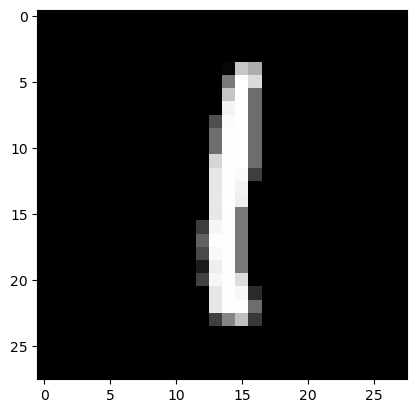

In [14]:
sample_image = X_train[:, 0, None].reshape((28, 28)) * 255
print(f'Label : {Y_train[0]}')
plt.gray()
plt.imshow(sample_image, interpolation='nearest')
plt.show()

# Funciones de utilidad

## Forward prop:
W: weights
b: bias


$$A^{[0]}_{(784\times m)}=X$$
$$Z^{[1]}_{(10\times m)}=W^{[1]}_{(10\times 784)}A^{[0]}_{((784\times m))}+b^{[1]}_{(10\times m)}$$
$$A^{[1]}_{(10\times m)}=g(Z^{[1]})=\text{ReLU}(z^{[1]})$$
$$Z^{[2]}_{(10\times m)}=W^{[2]}_{(10\times 10)}A^{[1]}_{(10\times m)}+b^{[2]}_{(10\times m)}$$
$$A^{[2]}_{(10\times m)}=\text{softmax}(Z^{[2]})$$

## Back prop:

$$dZ^{[2]}_{(10\times m)}=2(A^{[2]}_{(10\times m)}-Y_{(10\times m)})$$
$$dW^{[2]}_{((10\times 10))}=\frac{1}{m}dZ{[2]}_{(10\times m)}A^{[1]T}_{(m\times 10)}$$
$$db^{[2]}_{(10\times 1)}=\frac{1}{m}\sum dZ^{[2]}_{(10\times 1)}$$
$$dZ^{[1]}_{(10\times m)}=W^{[2]T}_{(10\times 10)}dZ^{[2]}_{(10\times m)}.*g'(Z^{[1]}_{(10\times m)})$$
$$dW^{[1]}_{(10\times 784)}=\frac{1}{m}dZ^{[1]}_{(10\times m)}X^{T}$$
$$db^{[1]}_{(10\times 1)}=\frac{1}{m}\sum dZ^{[1]}_{(10\times 1)}$$

## Update params

$$W^{[1]}=W^{[1]}-\alpha dW^{[1]}$$
$$b^{[1]}=b^{[1]}-\alpha db^{[1]}$$
$$W^{[2]}=W^{[2]}-\alpha dW^{[2]}$$
$$b^{[2]}=b^{[2]}-\alpha db^{[2]}$$

In [15]:
# Params initialization
def init_params():
    w1 = np.random.rand(10, 784) - 0.5
    b1 = np.random.rand(10, 1) - 0.5
    w2 = np.random.rand(10, 10) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return w1, b1, w2, b2

# Rectified Linear Unit
def relu(z):
    return np.maximum(z, 0)

# Softmax function
def softmax(z):
    return np.exp(z) / np.sum(z)

# Forward prop
def forward_prop(x, w1, b1, w2, b2):
    z1 = w1.dot(x) + b1 # (10, m)
    a1 = relu(z1) # (10, m)
    z2 = w2.dot(a1) + b2 # (10, m)
    a2 = softmax(z2) # (10, m)
    return z1, a1, z2, a2

# One-hot encoding
def one_hot(y):
    one_hot_y = np.zeros((y.max()+1,y.size))
    one_hot_y[y,np.arange(y.size)] = 1
    return one_hot_y

# Derivative ReLu
def deriv_relu(z):
    return z>0

# Back prop
def back_prop(x, y, z1, a1, a2, w2):
    m = y.size
    one_hot_y = one_hot(y)
    dz2 = 2 * (a2 - one_hot_y) # (10, m)
    dw2 = 1 / m * dz2.dot(a1.T) # (10, 10)
    db2 = 1 / m * np.sum(dz2) # (10, 1)
    dz1 = w2.T.dot(dz2) * deriv_relu(z1) # (10, m)
    dw1 = 1 / m * dz1.dot(x.T) # (10, 784)
    db1 = 1 / m * np.sum(dz1) # (10, 1)
    return dw1, db1, dw2, db2

# Update parameters
def update_params(w1, b1, w2, b2, dw1, db2, dw2, db1, alpha):
    w1 = w1 - alpha * dw1
    b1 = b1 - alpha * db1
    w2 = w2 - alpha * dw2
    b2 = b2 - alpha * db2
    return w1, b1, w2, b2


In [16]:
# Predictions
def get_predictions(a2):
    return np.argmax(a2, 0)

# Accuracy
def get_accuracy(predictions, y):
    print(predictions, y)
    return np.sum(predictions == y) / y.size

# Gradient descent
def gradient_descent(x, y, alpha, iterations):
    w1, b1, w2, b2 = init_params()
    for i in range(iterations):
        z1, a1, z2, a2 = forward_prop(x, w1, b1, w2, b2)
        dw1, db1, dw2, db2 = back_prop(x, y, z1, a1, a2, w2)
        w1, b1, w2, b2 = update_params(w1, b1, w2, b2, dw1, db2, dw2, db1, alpha)
        if i % 10 == 0:
            print(f'Iteration: {i}')
            print(f'Accuracy: {get_accuracy(get_predictions(a2), y)}')
    return w1, b1, w2, b2

In [17]:
w1, b1, w2, b2 = gradient_descent(X_train, Y_train, 0.05, 10000)

Iteration: 0
[9 0 9 ... 7 9 0] [1 0 1 ... 6 1 2]
Accuracy: 0.11504878048780488
Iteration: 10
[7 8 8 ... 1 8 3] [1 0 1 ... 6 1 2]
Accuracy: 0.1369268292682927
Iteration: 20
[1 9 1 ... 1 1 3] [1 0 1 ... 6 1 2]
Accuracy: 0.3320975609756098
Iteration: 30
[1 3 1 ... 6 1 3] [1 0 1 ... 6 1 2]
Accuracy: 0.3844878048780488
Iteration: 40
[1 0 1 ... 1 1 3] [1 0 1 ... 6 1 2]
Accuracy: 0.3792439024390244
Iteration: 50
[1 0 1 ... 1 1 3] [1 0 1 ... 6 1 2]
Accuracy: 0.42453658536585365
Iteration: 60
[1 3 8 ... 1 1 3] [1 0 1 ... 6 1 2]
Accuracy: 0.38646341463414635
Iteration: 70
[1 7 1 ... 1 1 3] [1 0 1 ... 6 1 2]
Accuracy: 0.4507317073170732
Iteration: 80
[1 0 1 ... 6 1 9] [1 0 1 ... 6 1 2]
Accuracy: 0.4763414634146341
Iteration: 90
[1 0 1 ... 6 1 3] [1 0 1 ... 6 1 2]
Accuracy: 0.5873414634146341
Iteration: 100
[1 0 1 ... 6 1 3] [1 0 1 ... 6 1 2]
Accuracy: 0.6692682926829269
Iteration: 110
[1 0 1 ... 6 1 3] [1 0 1 ... 6 1 2]
Accuracy: 0.5404634146341464
Iteration: 120
[1 3 1 ... 6 1 3] [1 0 1 ... 6 1 

In [18]:
def make_predictions(x, w1, b1, w2, b2):
    _, _, _, a2 = forward_prop(x, w1, b1, w2, b2)
    predictions = get_predictions(a2)
    return predictions

def test_prediction(image, label, w1, b1, w2, b2):
    current_image = image
    prediction = make_predictions(image, w1, b1, w2, b2)
    label = label
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [1]
Label:  1


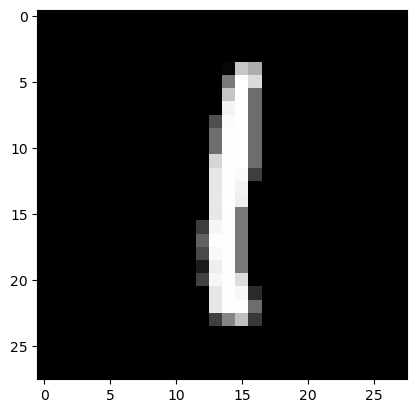

Prediction:  [0]
Label:  0


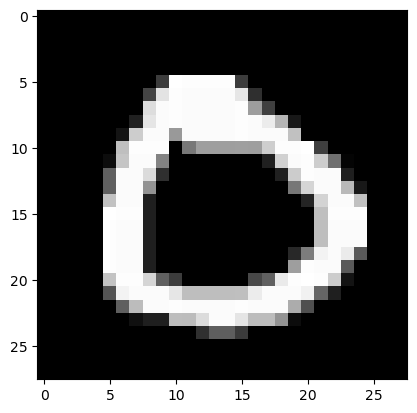

Prediction:  [1]
Label:  1


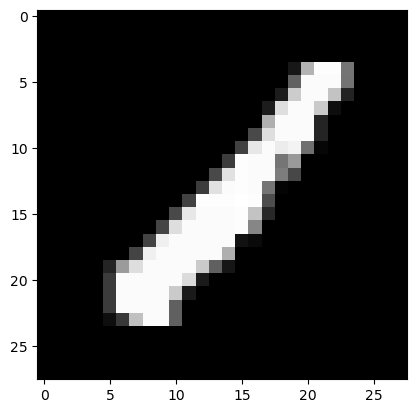

Prediction:  [8]
Label:  0


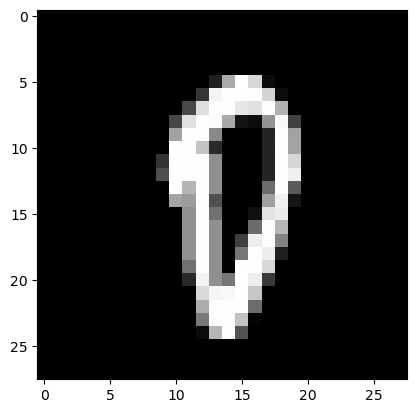

In [19]:
test_prediction(X_train[:, 0, None], Y_train[0], w1, b1, w2, b2)
test_prediction(X_train[:, 1, None], Y_train[1], w1, b1, w2, b2)
test_prediction(X_train[:, 2, None], Y_train[2], w1, b1, w2, b2)
test_prediction(X_train[:, 3, None], Y_train[3], w1, b1, w2, b2)

In [20]:
dev_predictions = make_predictions(X_test, w1, b1, w2, b2)
get_accuracy(dev_predictions, Y_test)

[6 8 3 1 0 8 2 4 5 0 2 9 8 7 6 3 4 0 5 1 2 6 4 5 3 2 4 5 4 1 3 2 3 0 3 3 8
 1 6 7 5 8 2 1 8 8 0 6 5 1 3 1 9 4 4 5 3 7 7 6 6 2 8 4 0 4 2 1 1 1 4 6 3 0
 0 2 2 3 5 9 9 4 1 4 9 4 7 4 4 6 8 1 9 8 7 9 7 4 4 0 3 2 5 8 1 6 8 1 2 4 3
 6 0 8 1 4 5 6 2 7 7 6 8 6 0 7 1 8 8 0 6 9 3 4 0 8 8 3 7 3 1 5 4 5 4 7 8 8
 5 1 5 7 6 5 2 4 5 1 2 0 7 9 6 5 2 1 5 0 3 8 2 3 3 3 4 3 9 3 7 5 7 6 1 9 7
 7 2 6 9 3 2 7 1 7 0 5 8 0 5 2 2 0 1 4 6 7 1 7 4 9 7 0 6 5 0 5 4 6 0 5 9 6
 4 2 4 8 2 2 6 2 5 7 4 3 7 5 7 5 6 4 1 9 1 2 2 4 5 9 4 1 1 9 2 2 7 7 8 9 9
 2 9 4 5 7 4 2 1 8 5 4 6 7 2 5 2 8 1 6 1 3 0 2 5 3 4 5 5 6 5 8 4 3 1 1 1 3
 2 3 4 7 4 1 8 8 1 7 5 6 3 1 5 8 0 5 8 3 6 8 1 1 6 3 3 4 2 3 8 3 3 4 2 5 3
 1 7 4 2 2 8 3 4 7 2 9 3 1 1 1 1 6 1 0 7 2 6 6 6 9 2 9 3 1 9 4 9 8 6 5 0 3
 6 4 0 8 2 2 3 7 3 9 9 6 3 3 4 0 4 0 9 6 7 3 1 4 7 1 1 6 4 7 9 7 9 8 6 6 2
 0 3 1 4 7 5 4 8 5 2 5 4 0 9 5 8 2 9 7 7 7 3 0 1 1 3 0 5 1 7 3 5 7 6 0 6 0
 0 2 5 7 6 9 2 1 7 6 6 7 1 1 2 7 3 9 5 4 5 1 5 3 4 1 5 3 9 0 1 8 2 2 8 5 8
 2 1 2 4 9 0 0 8 3 9 6 2 

0.903